# Машинное обучение, ФКН ВШЭ

## Практическое задание 6. Разложение ошибки на смещение и разброс

### Общая информация

Дата выдачи: 24.11.2021

Мягкий дедлайн: 23:59MSK 07.12.2021


Жесткий дедлайн: 23:59MSK 10.12.2021

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-06-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями бутстрапа для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
from sklearn.datasets import load_boston

In [3]:
boston = load_boston()

In [4]:
X = boston["data"]
y = boston["target"]

In [5]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [6]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

34.82671936027573

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (3 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [7]:
from tqdm import tqdm
import copy

In [8]:
def compute_biase_variance(regressor, X, y, num_runs=1000):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)
    
    :returns: bias (float), variance (float), error (float) 
    each value is computed using bootstrap
    """
    indexes = np.arange(X.shape[0])
    pred = np.zeros((X.shape[0], num_runs))
    ind = copy.deepcopy(pred)
    for run in tqdm(range(num_runs)):
        ind_cur = np.random.choice(X.shape[0], X.shape[0])
        oob = np.setdiff1d(indexes, ind_cur)
        model = regressor.fit(X[ind_cur], y[ind_cur])
        pred[oob, run] = model.predict(X[oob])
        ind[oob, run] = 1
    length = X.shape[0] - np.sum((np.sum(ind, axis = 1) == 0))
    n_oob = (np.sum(ind[:,:] != 0, axis = 1) * np.ones(pred.shape).T).T
    
    bias_X = np.sum(pred / n_oob, axis = 1) - y
    bias = np.sum(np.power(bias_X, 2) / length, axis = 0)
    
    variance_X = pred - (np.sum(pred / n_oob, axis = 1) * (ind == 1).T).T
    variance = np.sum(np.sum(np.power(variance_X, 2) / n_oob, axis = 1) / length, axis = 0)
    
    error = np.sum(np.sum(np.power(pred - (y * (ind == 1).T).T, 2) / n_oob, axis = 1) / length, axis = 0)
    return bias, variance, error

__2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
regressors = [LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor()]
bias, variance, error = np.empty(3), np.empty(3), np.empty(3)
for i, regressor in enumerate(regressors):
    bias[i], variance[i], error[i] = compute_biase_variance(regressor = regressor, X = X, y = y, num_runs=500)
    i+=1

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [03:16<00:00,  2.55it/s]


In [10]:
res = pd.DataFrame(columns = ['bias', 'variance', 'error'], index = ['lr', 'tree', 'rf'])
res['bias'] = bias
res['variance'] = variance
res['error'] = error
res

,bias,variance,error
lr,23.726312,0.928974,24.655286
tree,10.351395,12.761574,23.112969
rf,10.563805,2.178212,12.742018


__3. (1 балл)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на занятиях (с комментарием)?

__Your answer here:__
Согласуются, полная ошибка действительно близка к сумме bias и variance. Шумом данных в данном случае можно пренебречь.

__4. (1 балл)__
Постройте бэггинг над всеми тремя моделями (линейная регрессия, решающее дерево, случайный лес). Вспомните обсуждение с лекции о том, во сколько раз в теории бэггинг уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

In [49]:
from sklearn.ensemble import BaggingRegressor
bias, variance, error = np.empty(4), np.empty(4), np.empty(4)
n = [15, 30, 50, 100]
for i, num_runs in enumerate(n):
    bias[i], variance[i], error[i] = compute_biase_variance(
        regressor = BaggingRegressor(LinearRegression()), X = X, y = y, num_runs=num_runs)
lr = pd.DataFrame(columns = ['bias', 'variance', 'error'], index = n)
lr['bias'] = bias
lr['variance'] = variance
lr['error'] = error
lr

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 29.48it/s]


,bias,variance,error
15,23.926851,0.840657,24.767508
30,23.925821,0.866155,24.791976
50,23.722605,1.071046,24.793651
100,23.692264,0.976953,24.669217


In [51]:
bias, variance, error = np.empty(4), np.empty(4), np.empty(4)
for i, num_runs in enumerate(n):
    bias[i], variance[i], error[i] = compute_biase_variance(
        regressor = BaggingRegressor(DecisionTreeRegressor()), X = X, y = y, num_runs=num_runs)
dt = pd.DataFrame(columns = ['bias', 'variance', 'error'], index = n)
dt['bias'] = bias
dt['variance'] = variance
dt['error'] = error
dt

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.77it/s]


,bias,variance,error
15,11.383597,2.861514,14.245112
30,10.796327,3.079273,13.875600
50,10.513518,3.368229,13.881746
100,10.736897,3.421560,14.158457


In [52]:
bias, variance, error = np.empty(4), np.empty(4), np.empty(4)
for i, num_runs in enumerate(n):
    bias[i], variance[i], error[i] = compute_biase_variance(
        regressor = BaggingRegressor(RandomForestRegressor(n_jobs=-1), n_jobs=-1), X = X, y = y, num_runs=num_runs)
rf = pd.DataFrame(columns = ['bias', 'variance', 'error'], index = n)
rf['bias'] = bias
rf['variance'] = variance
rf['error'] = error
rf

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [04:09<00:00,  2.49s/it]


,bias,variance,error
15,12.118197,0.963218,13.081416
30,12.120729,1.394844,13.515573
50,11.678973,1.304776,12.983749
100,12.075959,1.409929,13.485888


__Your answer here:__
В теории бэггинг уменьшает ошибку композиции нескореллированных базовых алгоритмов как 1/N. В данном случае это не выполняется, так как, судя по всему, базовые алгоритмы недостаточно нескореллированные, либо сетка взята неподходящая. Однако применение бэггинга в сравнении с отсутствием композиции дает уменьшение variance. Особенно на алгоритмах, чувствительных к входным данным. Например, дерево выдавало ошибку variance $\approx$ 12, а на бэггинге получилось уже порядка 3. Аналогично с RF, 3.2 против 1.3

### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__5. (2 балла)__

Реализуйте функцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [24]:
from sklearn.model_selection import train_test_split
def plot_predictions(regressor, X, y, num_runs=100, num_test_objects=10, title=""):
    """
    plot graphics described above
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=num_test_objects, random_state = 51261)
    for i in range(num_runs):
        ind_cur = np.random.choice(y_train.shape[0], y_train.shape[0])
        regressor.fit(X_train[ind_cur], y_train[ind_cur])
        y_test_pred = regressor.predict(X_test)
        colors = [plt.cm.get_cmap('Set2', num_test_objects)(x)
            for x in range(num_test_objects)]
        plt.scatter(np.arange(num_test_objects), y_test_pred, c=colors)

    plt.scatter(np.arange(num_test_objects), y_test, c='black')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)
    plt.grid()
    plt.show()

__6. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

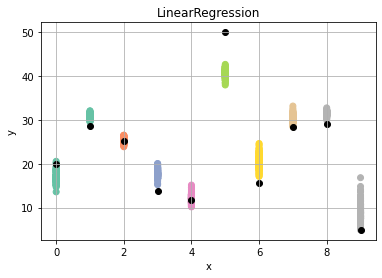

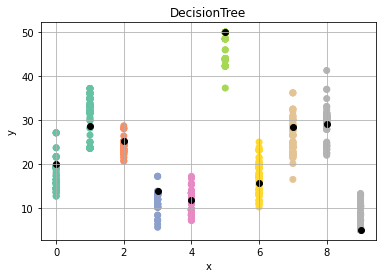

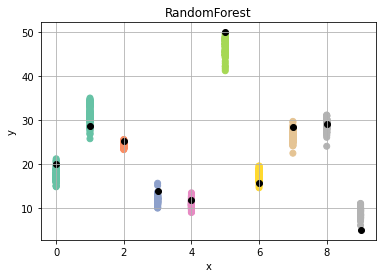

In [25]:
plot_predictions(LinearRegression(), X, y, num_runs=100, title='LinearRegression')
plot_predictions(DecisionTreeRegressor(), X, y, num_runs=100, title='DecisionTree')
plot_predictions(RandomForestRegressor(n_jobs=-1), X, y, num_runs=100, title='RandomForest')

__7. (1 балл)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма. 

__Your answer here:__ На данных графиках смещение и разброс примерно характеризуются матожиданием и дисперсией ответов на тесте для каждого объекта на каждой модели. У линейной регрессии довольно большое смещение, алгоритм слишком слабый для предсказания таких данных и часто (причем именно систематически, то есть по мат ожиданию) ошибается в прогнозах. В то же время, дерево довольно неплохо попадает по смещению (то есть матожидание близко к реальному ответу), но разброс(дисперсия ответов на разных реализациях дерева) гораздо выше чем у линейной модели, что означает, что дерево очень неустойчиво. Как говорил оксимирон "So any ladies looking for fellas who into personal growth. Don't look for battlers, go get yourself a man that can do both". Вот RandomForest $-$ это алгоритм, который can do both. Он хорош и по смещению, и по разбосу.

### Изменение bias и variance при изменении гиперпараметров

__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 307.80it/s]


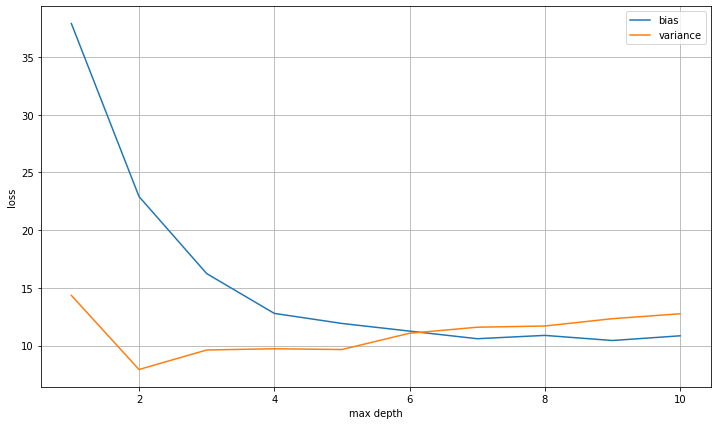

In [43]:
biases = []
variances = []
for i in np.arange(1, 11):
    bias, variance, error = compute_biase_variance(
            DecisionTreeRegressor(max_depth=i), X, y, num_runs=150
        )
    biases.append(bias)
    variances.append(variance)
plt.figure(figsize=(12, 7))
plt.plot(np.arange(1, 11), biases, label='bias')
plt.plot(np.arange(1, 11), variances, label='variance')
plt.xlabel('max depth')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.show()

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 258.21it/s]


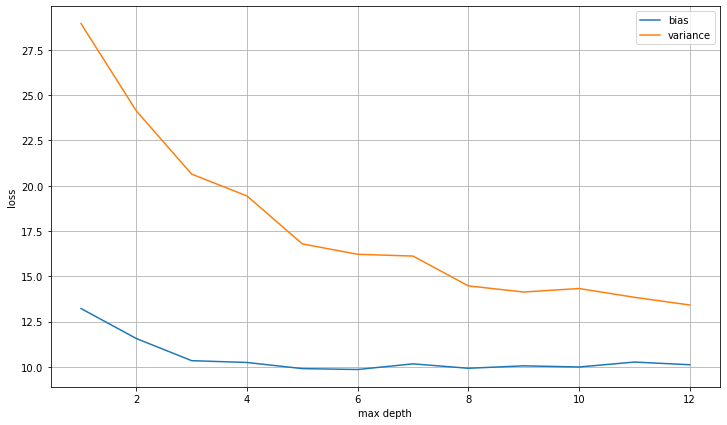

In [44]:
biases = []
variances = []
for i in np.arange(1, X.shape[1]):
    bias, variance, error = compute_biase_variance(DecisionTreeRegressor(max_features=i), X, y, num_runs=150)
    biases.append(bias)
    variances.append(variance)
plt.figure(figsize=(12, 7))
plt.plot(np.arange(1, X.shape[1]), biases, label='bias')
plt.plot(np.arange(1, X.shape[1]), variances, label='variance')
plt.xlabel('max features')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.show()

__9. (0 баллов)__

Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга:

100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [03:39<00:00,  1.46s/it]


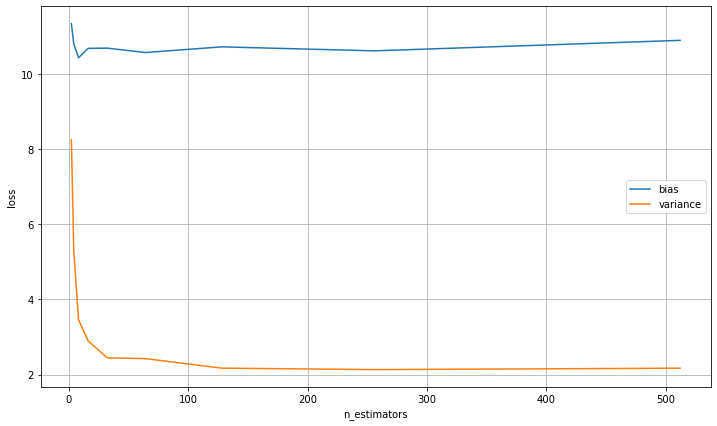

In [47]:
biases = []
variances = []
n_estimators = 2 ** np.arange(1, 10)
for n in n_estimators:
    bias, variance, error = compute_biase_variance(RandomForestRegressor(n_estimators=n, n_jobs=-1), X, y, num_runs=150)
    biases.append(bias)
    variances.append(variance)
plt.figure(figsize=(12, 7))
plt.plot(n_estimators, biases, label='bias')
plt.plot(n_estimators, variances, label='variance')
plt.xlabel('n_estimators')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.show()

100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [01:49<00:00,  1.37it/s]


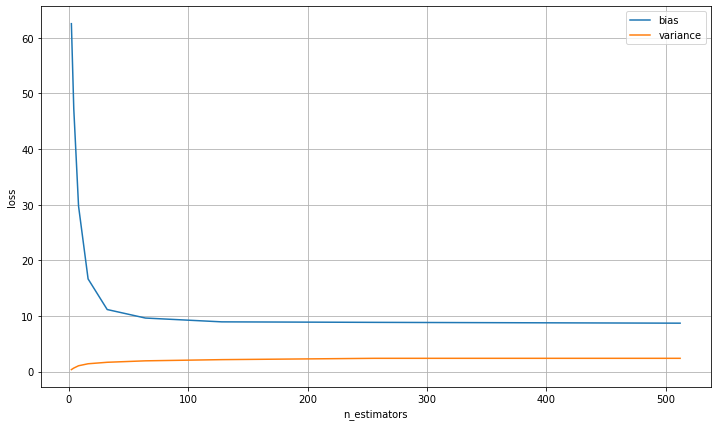

In [46]:
from sklearn.ensemble import GradientBoostingRegressor
biases = []
variances = []
for n in n_estimators:
    bias, variance, error = compute_biase_variance(GradientBoostingRegressor(n_estimators=n), X, y, num_runs=150)
    biases.append(bias)
    variances.append(variance)
plt.figure(figsize=(12, 7))
plt.plot(n_estimators, biases, label='bias')
plt.plot(n_estimators, variances, label='variance')
plt.xlabel('n_estimators')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.show()

__10. (2 балла)__

Прокомментируйте графики (всего 4 графика): почему они имеют такой вид.

__Your answer here:__ 

На первом графике bias падает с увеличением глубины, так как дерево бОльшей глубины имеет бОльшую сложность и, соответственно, меньше смещение. variance же растет, так как деревья бОльшей глубины больше склонны к переобучению

На втором графике и variance падает, а bias после небольшого падения, остается примерно постоянным. Я полагаю, что минимума на графике не присутствует, так как сетка для такого графика взята слишком маленькая, да и в целом до 10 max_features деревья становятся более устойчивыми к изменениям.

На третьем графике bias не меняется, что соответсвует теории, а variance падает вначале как 1/N, а затем выходит на плато, так как алгоритмы, судя по всему, становятся слишком скорелированными

На четвертом графике variance и bias в какой-то момент выходят на постоянное значение, т.к. бустинг имеет свойство затухать на больших N (следующие итерации не дают существенного вклада и композиция сходится)

Вставьте картинку, описывающую ваш опыт выполнения этого ДЗ.